## Speech Emotion Recognition using CNN

#### How do I apply CNN to audio?

* Audio can be thought of an image > Spectogram/MFCC = image
* time frequency = x,y
* amplitude = pixel value
* 13 MFCCs, hop_length=512
* Audio data can be compared to grey scale image, depth=1

In [4]:
import os
import librosa
import math
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
# these lines were required as keras could not identify my system GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [6]:
# loading mfcc data > conversion of audio files to mfcc is done in the preprocessing of audio notebook
def load_data(dataset_path):
    with open(dataset_path,'r') as fp:
        data = json.load(fp)
        
    #convert lists to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    
    return inputs,targets

In [7]:
JSON_PATH = "./outputs/ravdess_complete.json"

In [8]:
# load the data
X,y = load_data(JSON_PATH)

In [9]:
X.shape,y.shape

((1438, 130, 13), (1438,))

In [10]:
#Emotion (0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised)
# selecting only calm,happy,angry 

X = X[(y!=0)]
y = y[(y!=0)]
X = X[(y!=3)]
y = y[(y!=3)]
X = X[(y<=4)]
y = y[(y<=4)]

In [11]:
# So I have now 2,3 and 4 in the training > it needs to be 0,1,2
y = np.where(y==1, 0, y)
y = np.where(y==2, 1, y)
y = np.where(y==4, 2, y)

In [12]:
y.shape, X.shape

((575,), (575, 130, 13))

In [13]:
# shape of each input entry : (number of samples per second/hop_length)*duration

In [14]:
def prepare_data(X,y,test_size,validation_size):
    
    # splitting data into train and test set
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size)
    
    # splitting data into train and validation set
    X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=validation_size)
    
    # add extra dimension , as sound files are treated like greyscale images
    X_train = X_train[...,np.newaxis] #4d array num_samples x 130 x 13 x 1
    X_test = X_test[...,np.newaxis]
    X_validation = X_validation[...,np.newaxis]
    return X_train,X_validation,X_test,y_train,y_validation,y_test

In [15]:
# splitting data into train,validation and test set
X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_data(X,y,test_size=0.25,validation_size=0.2)

In [16]:
X_train.shape

(460, 130, 13, 1)

In [17]:
def build_model(input_shape):
    #create model
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.BatchNormalization())
    
    #1st conv layer
    model.add(tf.keras.layers.Conv2D(8,(3,3),activation="relu",input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    #2nd conv layer
    #model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape))
    #model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())

    #3rd conv layer
    #model.add(tf.keras.layers.Conv2D(32,(2,2),activation="relu",input_shape=input_shape))
    #model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    
    #flatten and feed to dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation="relu",input_shape=(3072,)))
    model.add(tf.keras.layers.Dropout(0.3))
    
    #output layer that feeds to softmax
    model.add(tf.keras.layers.Dense(3,activation="softmax"))
    
    return model
    

In [18]:
# building the CNN
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

model = build_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics=["accuracy"])


In [19]:
# fitting the model
history=model.fit(X_train,y_train,validation_data=(X_validation,y_validation),batch_size=32,epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 116ms/step - loss: 1.8805 - accuracy: 0.3597 - val_loss: 2.5962 - val_accuracy: 0.4348
Epoch 2/100
15/15 [==============================] - 1s 41ms/step - loss: 0.7898 - accuracy: 0.6363 - val_loss: 2.1203 - val_accuracy: 0.4783
Epoch 3/100
15/15 [==============================] - 1s 41ms/step - loss: 0.6468 - accuracy: 0.7187 - val_loss: 2.5255 - val_accuracy: 0.4261
Epoch 4/100
15/15 [==============================] - 1s 42ms/step - loss: 0.5399 - accuracy: 0.7621 - val_loss: 1.7264 - val_accuracy: 0.5565
Epoch 5/100
15/15 [==============================] - 1s 41ms/step - loss: 0.3981 - accuracy: 0.8671 - val_loss: 1.6296 - val_accuracy: 0.4783
Epoch 6/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3921 - accuracy: 0.8462 - val_loss: 1.6007 - val_accuracy: 0.4696
Epoch 7/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3421 - accuracy: 0.8834 - val_loss: 1.1942 - val_accuracy: 0.5391
Epoch

15/15 [==============================] - 1s 39ms/step - loss: 0.0173 - accuracy: 0.9978 - val_loss: 0.5641 - val_accuracy: 0.8783
Epoch 59/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.5220 - val_accuracy: 0.8783
Epoch 60/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0149 - accuracy: 0.9943 - val_loss: 0.6021 - val_accuracy: 0.8522
Epoch 61/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0331 - accuracy: 0.9918 - val_loss: 0.6068 - val_accuracy: 0.8609
Epoch 62/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0553 - accuracy: 0.9778 - val_loss: 0.4857 - val_accuracy: 0.8522
Epoch 63/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0593 - accuracy: 0.9661 - val_loss: 0.3911 - val_accuracy: 0.8609
Epoch 64/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0257 - accuracy: 0.9967 - val_loss: 0.4659 - val_accuracy: 0.9043
Epoch 65/100

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 8)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 8)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 8)          32        
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                196672    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [21]:
import pandas as pd
pd.DataFrame(history.history["accuracy"]).to_csv('CNN_train_acc.csv')
pd.DataFrame(history.history["val_accuracy"]).to_csv('CNN_val_acc.csv')

In [22]:
#Evaluating the model
test_error,test_accuracy = model.evaluate(X_test,y_test,verbose=1)
test_error,test_accuracy

5/5 [==============================] - 0s 20ms/step - loss: 0.1138 - accuracy: 0.9722


(0.11378681659698486, 0.9722222089767456)

In [34]:
#model.save('CNN_model_calm_happy_angry.h5')

In [24]:
def plot_history(history):
    fig, axs = plt.subplots(2,figsize=(12,8))
    
    #create the accuracy subplot
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    #create the error subplot
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()   
    

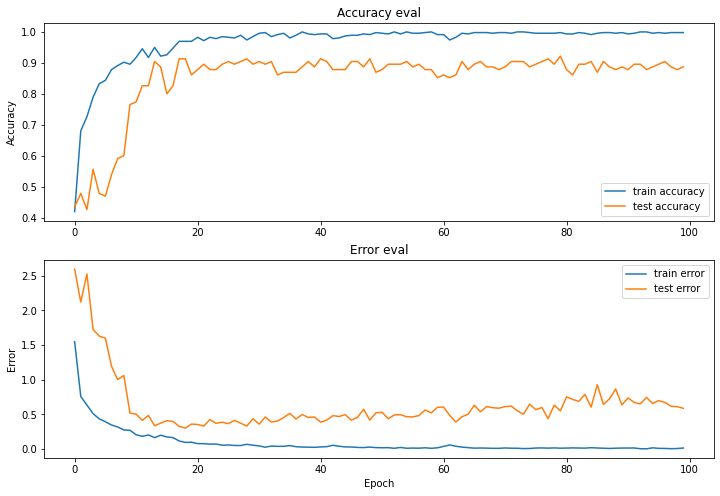

In [25]:
plot_history(history)

## Evaluating the model performance

In [26]:
def predict(model,X):
    #X = X[np.newaxis,...] #size of X (1,130,13,1) [Conversion to be done if entering one value],
    prediction = model.predict(X) #prediction contains 3 values - probability for each genre [[0.1, 0.2, ..]],
    #print(prediction),
    #extract index with max value,
    predicted_index = np.argmax(prediction,axis=1)
    return predicted_index

In [28]:
y_pred = predict(model,X_test)

In [29]:
confusion_matrix(y_test,y_pred)

array([[42,  0,  0],
       [ 1, 49,  1],
       [ 1,  1, 49]], dtype=int64)

In [30]:
y_train_pred = predict(model,X_train)

In [31]:
y_validation_pred = predict(model,X_validation)

In [32]:
confusion_matrix(y_train,y_train_pred)

array([[153,   0,   0],
       [  0, 158,   0],
       [  0,   0, 149]], dtype=int64)

In [33]:
confusion_matrix(y_validation,y_validation_pred)

array([[38,  0,  0],
       [ 5, 26,  3],
       [ 2,  3, 38]], dtype=int64)

In [ ]:
# Emotions : calm : 0,happy : 1,angry : 2